In [4]:
#!pip install gdown

In [5]:
#!pip install keras-tuner

In [6]:
#model for ASL project
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import itertools
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import time
from tensorflow.keras.callbacks import Callback
from keras.callbacks import EarlyStopping
import gdown
from keras.regularizers import l2
import keras_tuner as kt

# File IDs for the CSV files
file_id_train = '1Jtx8g3kartST38gtRKcqQf9RxGNE2l76'  
file_id_test = '1Yz-nIiuk7trjFBZQC7vu19gguzIPX255'   

# URLs for downloading the CSV files
csv_file_url_train = f'https://drive.google.com/uc?id={file_id_train}'
csv_file_url_test = f'https://drive.google.com/uc?id={file_id_test}'

# Download CSV files
gdown.download(csv_file_url_train, 'sign_mnist_train.csv', quiet=False)
gdown.download(csv_file_url_test, 'sign_mnist_test.csv', quiet=False)

# Read CSV files
train_data = pd.read_csv('sign_mnist_train.csv')
test_data = pd.read_csv('sign_mnist_test.csv')

# Concatenate train and test data
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Write the combined data to a new CSV file
#combined_data.to_csv('combined_sign_mnist.csv', index=False)

print(combined_data.shape)
combined_data.head()

Downloading...
From: https://drive.google.com/uc?id=1Jtx8g3kartST38gtRKcqQf9RxGNE2l76
To: /Users/sofiautoft/ML/ASLproject/sign_mnist_train.csv
100%|██████████| 83.3M/83.3M [00:06<00:00, 13.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Yz-nIiuk7trjFBZQC7vu19gguzIPX255
To: /Users/sofiautoft/ML/ASLproject/sign_mnist_test.csv
100%|██████████| 21.8M/21.8M [00:02<00:00, 10.5MB/s]


(34627, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [7]:
#split data into features (X) and labels (y)
X = combined_data.drop(columns=['label'])
y = combined_data['label']

#first, split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state = 123)

#then, split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)

Text(0.5, 0, 'letters')

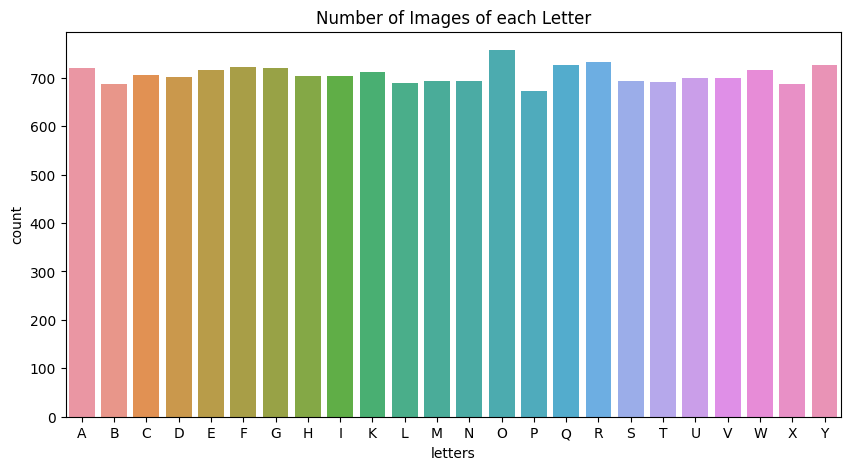

In [8]:
#create dictionary to go from number -> alphabetical letter
num_to_letters = {}
for num in range(0, 25):
    letter = chr(num + 65)
    num_to_letters[num] = letter

Y_train_labels = [num_to_letters[num] for num in y_train]

Y_train_labels = sorted(Y_train_labels)

#visualize number of letters classes
plt.figure(figsize=(10,5))
g = sns.countplot(x = Y_train_labels)
plt.title("Number of Images of each Letter")
plt.xlabel("letters")
#no data for 'J' = 9 and 'Z' 25 since they are motions


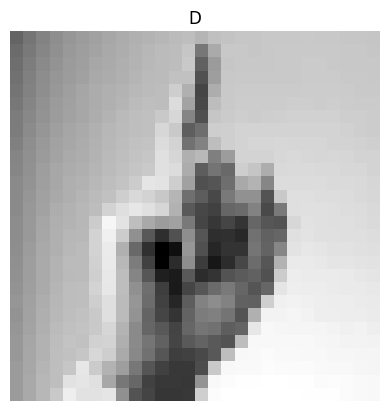

In [9]:
#plot a sample
img = X.iloc[0].values
img = img.reshape((28,28))
plt.imshow(img, cmap='gray')
key = y.iloc[0]
plt.title(num_to_letters[key])
plt.axis("off")
plt.show()

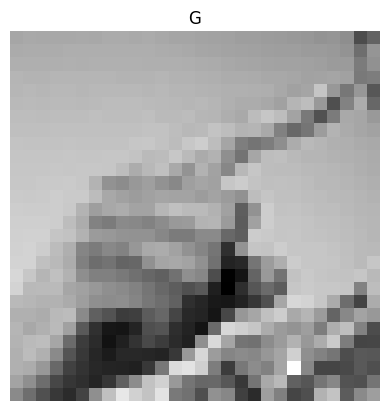

In [10]:
img = X.iloc[1].values
img = img.reshape((28,28))
plt.imshow(img, cmap='gray')
key = y.iloc[1]
plt.title(num_to_letters[key])
plt.axis("off")
plt.show()

In [11]:
#normalize the data (must be between 0 and 1 to feed our model)
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

print("Train shape: ",X_train.shape)
print("Test shape: ",X_test.shape)
print("Validation shape: ",X_test.shape)

Train shape:  (16966, 784)
Test shape:  (10389, 784)
Validation shape:  (10389, 784)


In [12]:
#reshape the data into 28x28
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)
X_val = X_val.values.reshape(-1,28,28,1)
print("Train shape: ",X_train.shape)
print("Test shape: ",X_test.shape)
print("Validation shape: ",X_val.shape)

Train shape:  (16966, 28, 28, 1)
Test shape:  (10389, 28, 28, 1)
Validation shape:  (7272, 28, 28, 1)


In [13]:
#one hot encoding
Y_train_encoded = to_categorical(y_train, num_classes = 25)
Y_test_encoded = to_categorical(y_test, num_classes=25)
Y_val_encoded =  to_categorical(y_val, num_classes=25)

In [14]:
# Define the unique identifiers for kernel sizes
kernel_sizes = [(3, 3), (5, 5), (8, 8)]
kernel_size_names = ['small', 'medium', 'large']

# Define the model-building function
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(filters=hp.Choice('filters', values=[8, 16, 32]),
                     kernel_size=kernel_sizes[kernel_size_names.index(hp.Choice('kernel_size', values=kernel_size_names))],
                     padding='same',
                     activation='relu',
                     input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Choice('dropout_1', values=[0.25, 0.3, 0.35])))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=16,
                     kernel_size=kernel_sizes[kernel_size_names.index(hp.Choice('kernel_size_2', values=kernel_size_names))],
                     padding='same',
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Choice('dropout_2', values=[0.25, 0.3, 0.35])))
    model.add(Flatten())
    model.add(Dense(256, activation="relu", kernel_regularizer=l2(0.001)))
    model.add(Dropout(hp.Choice('dropout_3', values=[0.3, 0.5, 0.6])))
    model.add(Dense(25, activation="softmax"))
    
    # Define optimizer
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=hp.Choice('learning_rate', values=[0.001, 0.01]))
    # Compile the model
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model

# Step 2: Instantiate the Tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='my_project'
)

# Step 3: Perform Hyperparameter Search
tuner.search(X_train, Y_train_encoded, epochs=50, validation_split = 0.3, callbacks=[EarlyStopping()])

# Step 4: Get the Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Step 5: Compile the Model with Best Hyperparameters
model = tuner.hypermodel.build(best_hps)
model.compile(optimizer=model.optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#Step 6: Augment Data
datagen = ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, 
        rotation_range = 10,  #randomly rotate images 5 degrees
        zoom_range = 0.3, #randomly zoom in 10%
        width_shift_range= 0.3,  #randomly shift images horizontally 10%
        height_shift_range= 0.3,  #randomly shift images vertically 10%
        horizontal_flip=False,  #randomly flip images set to false - could this affect the sign if True (?)
        vertical_flip=False)  #randomly flip images set to false - could this affect the sign if True (?)

datagen.fit(X_train)

#Step 7: Keep track of Training Time
class TrainingTimeCallback(Callback):
    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        end_time = time.time()
        training_duration = end_time - self.start_time
        print("Training duration:", training_duration, "seconds")

#create an instance of the custom callback
time_callback = TrainingTimeCallback()

# Step 6: Train the Model

data = X_train.shape[0]
epochs = 118 #whole number options = 1, 2, 59, 118, 143, 286, 8483, 16966
batch_size = int(data / epochs)

#calculate the steps per epoch
steps_per_epoch = int(X_train.shape[0] / batch_size)

#define early stopping criteria
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1, min_delta = 0.01, restore_best_weights = True)

#fit the model
history = model.fit(datagen.flow(X_train, Y_train_encoded, batch_size=batch_size), epochs=epochs, 
                    validation_data=(X_test, Y_test_encoded), steps_per_epoch=steps_per_epoch, callbacks=[time_callback, early_stopping])


Reloading Tuner from my_dir/my_project/tuner0.json
Epoch 1/118
118/118 [==============================] - 9s 67ms/step - loss: 3.6551 - accuracy: 0.0794 - val_loss: 3.4660 - val_accuracy: 0.0622
Epoch 2/118
118/118 [==============================] - 13s 109ms/step - loss: 3.2545 - accuracy: 0.1302 - val_loss: 3.2766 - val_accuracy: 0.1086
Epoch 3/118
118/118 [==============================] - 11s 94ms/step - loss: 2.9657 - accuracy: 0.1824 - val_loss: 3.3325 - val_accuracy: 0.1557
Epoch 4/118
118/118 [==============================] - 13s 111ms/step - loss: 2.6882 - accuracy: 0.2383 - val_loss: 2.5143 - val_accuracy: 0.2988
Epoch 5/118
118/118 [==============================] - 28s 237ms/step - loss: 2.4402 - accuracy: 0.2988 - val_loss: 1.7109 - val_accuracy: 0.5463
Epoch 6/118
118/118 [==============================] - 11s 90ms/step - loss: 2.2831 - accuracy: 0.3391 - val_loss: 1.4907 - val_accuracy: 0.5941
Epoch 7/118
118/118 [==============================] - 11s 97ms/step - loss: 

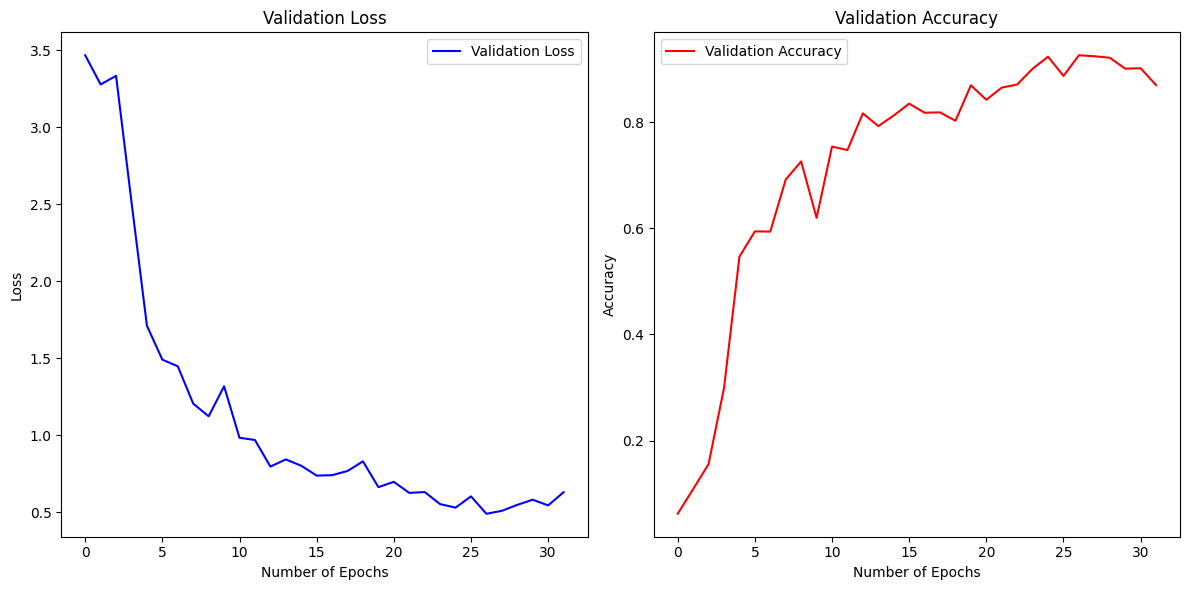

In [15]:
plt.figure(figsize=(12, 6))

#plot validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'], color='b', label="Validation Loss")
plt.title("Validation Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()

#plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], color='r', label="Validation Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

325/325 [==============================] - 1s 4ms/step
Number of misclassifications: 770


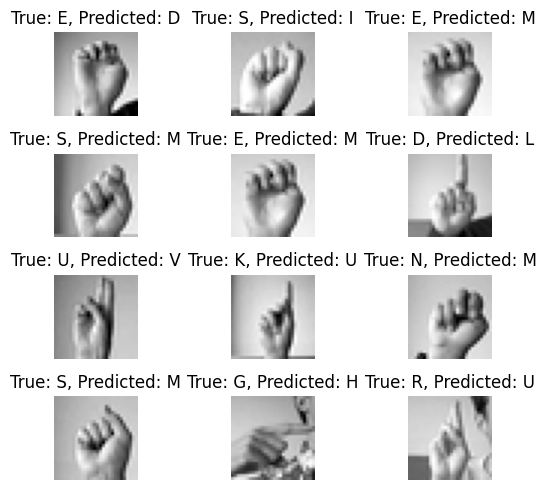

In [16]:
Y_pred = model.predict(X_test)
Y_pred_labels = [num_to_letters[np.argmax(pred)] for pred in Y_pred]
Y_test_labels = [num_to_letters[num] for num in y_test]

# Find misclassified indices
misclassified_indices = []
for i in range(len(y_test)):
    if Y_pred_labels[i] != Y_test_labels[i]:
        misclassified_indices.append(i)

print("Number of misclassifications:", len(misclassified_indices))

# Visualize misclassified images all at once
plt.figure(figsize=(6, 5))
for i, index in enumerate(misclassified_indices[:12]):
    plt.subplot(4, 3, i + 1)
    plt.imshow(X_test[index].reshape(28, 28), cmap='gray')
    true_label = Y_test_labels[index]
    predicted_label = Y_pred_labels[index]
    plt.title(f"True: {true_label}, Predicted: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

325/325 [==============================] - 1s 4ms/step
Number of correct classifications:  9619


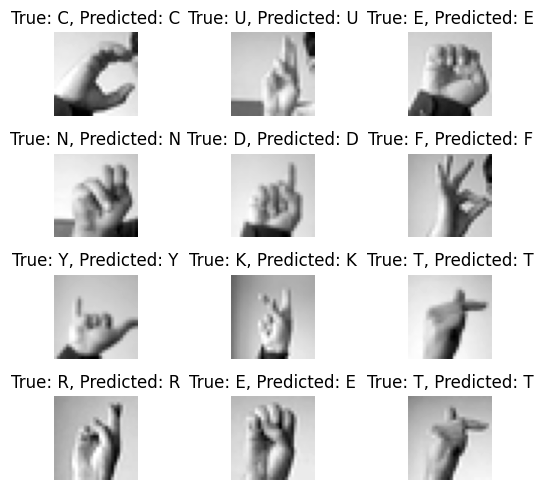

In [17]:
Y_pred = model.predict(X_test)
Y_pred_labels = [num_to_letters[np.argmax(pred)] for pred in Y_pred]
Y_test_labels = [num_to_letters[num] for num in y_test]



#find correctly classified indices
classified_indices = []
for i in range(len(y_test)):
    if (Y_pred_labels[i]) == (Y_test_labels[i]):
        classified_indices.append(i)
print("Number of correct classifications: " , len(classified_indices))

#visualize correctly classified images all at once
plt.figure(figsize=(6, 5))
for i, index in enumerate(classified_indices[:12]):
    plt.subplot(4, 3, i + 1)
    plt.imshow(X_test[index].reshape(28, 28), cmap='gray')
    true_label = Y_test_labels[index]
    predicted_label = num_to_letters[np.argmax(Y_pred[index])]
    plt.title(f"True: {true_label}, Predicted: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

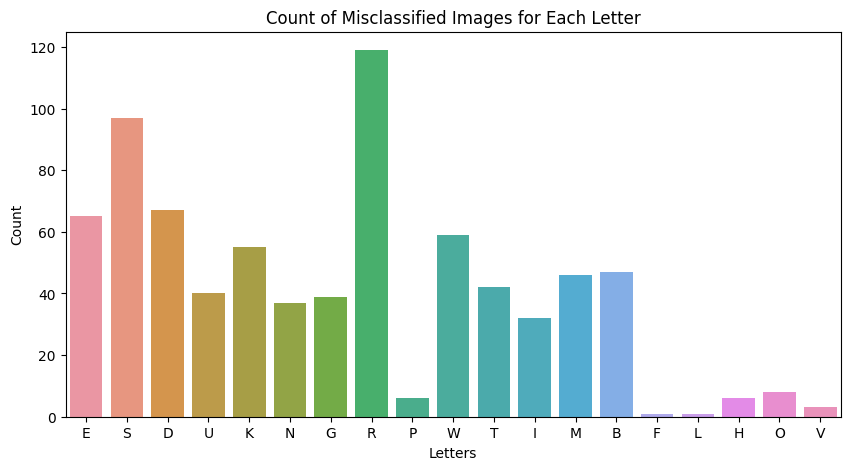

In [18]:
#convert numerical labels in Y_pred to alphabetical letters
Y_pred_labels = [num_to_letters[np.argmax(pred)] for pred in Y_pred]

#count the number of misclassified images for each letter
misclassified_counts = {}
for true_label, pred_label in zip(Y_test_labels, Y_pred_labels):
    if true_label != pred_label:
        misclassified_counts[true_label] = misclassified_counts.get(true_label, 0) + 1

#plot the count of misclassified images for each letter
plt.figure(figsize=(10, 5))
sns.barplot(x = list(misclassified_counts.keys()), y = list(misclassified_counts.values()))
plt.title("Count of Misclassified Images for Each Letter")
plt.xlabel("Letters")
plt.ylabel("Count")
plt.show()


In [19]:
#save trained model

from tensorflow.keras.models import save_model

model.save("CNN_model.h5")  # Save the model to a file named "my_model.h5"


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
